# Import Liberaries

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd

sys.path.append('/home/mahdi/WaterBalance/')

# Varables

In [3]:
PATH_DATA = "/mnt/e/Term2/payan_name/import/DataQDWB/"

# mashhad
# LAT_MIN = 35.80
# LAT_MAX = 37.11
# LON_MIN = 58.31
# LON_MAX = 60.14

# USA
LAT_MIN = 43.30
LAT_MAX = 44.60
LON_MIN = -109.40
LON_MAX = -107.40


# Functions

In [4]:
def mask_nc_file(
    nc,
    variable,
    lat_min,
    lat_max,
    lon_min,
    lon_max
):
    with xr.open_dataset(nc) as xr_nc:
        result = xr_nc.sel(
            lat = slice(lat_max, lat_min),
            lon = slice(lon_min, lon_max),
        )
    return result

# Load Data

In [5]:
# mm d-1 - precipitation
P = mask_nc_file(
    nc = PATH_DATA + "P_2022031.nc",
    variable = "precipitation",
    lat_min = LAT_MIN,
    lat_max = LAT_MAX,
    lon_min = LON_MIN,
    lon_max = LON_MAX
)


# open the netCDF4 file
soil_moisture = nc.Dataset(PATH_DATA + "LPRM-AMSR2_L3_A_SOILM3_V001_20220131013015.nc4")

# print the variables in the dataset
print(soil_moisture)


mashhad = gpd.read_file('/mnt/e/Term2/WERI/test/Export_Output.shp')

usa = gpd.read_file('/mnt/e/Term2/payan_name/import/sample/usa.shp')


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    dimensions(sizes): Longitude(1440), Latitude(720)
    variables(dimensions): float32 Latitude(Latitude), float32 Longitude(Longitude), int16 ts(Longitude, Latitude), int16 soil_moisture_c1(Longitude, Latitude), int16 opt_depth_c1(Longitude, Latitude), int16 soil_moisture_c2(Longitude, Latitude), int16 opt_depth_c2(Longitude, Latitude), int16 soil_moisture_x(Longitude, Latitude), int16 opt_depth_x(Longitude, Latitude), int16 mask(Longitude, Latitude), int16 soil_moisture_c1_error(Longitude, Latitude), int16 soil_moisture_c2_error(Longitude, Latitude), int16 soil_moisture_x_error(Longitude, Latitude), int16 frequency_map(Longitude, Latitude), float64 scantime(Longitude, Latitude)
    groups: 


In [6]:
from qdwb.primary_surface_flow.primary_surface_flow import *
from qdwb.primary_surface_flow.asset import *


R = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = 30,
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[0]
for i in list(P.precipitation.values.flatten())])



underground_runoff = np.array([PrimarySurfaceFlow.scs(
    precipitation = float(i),
    curve_number = 30,
    rsa = True,
    antecedent_precipitation = 100,
    is_growing_season = True
)[1]
for i in list(P.precipitation.values.flatten())])


R_array = R.reshape(1,13,20)
underground_runoff_array = underground_runoff.reshape(1,13,20)

# array_dr = np.array([[[1,2,5], [3,4,6]]])
# array_dr.shape
ds_array = P.assign(Runoff=(['time', 'lat', 'lon'], R_array))
ds_array_1 = ds_array.assign(underground_runoff=(['time', 'lat', 'lon'], underground_runoff_array))
ds_array_1

<xarray.Dataset>
Dimensions:             (lon: 20, lat: 13, time: 1)
Coordinates:
  * lon                 (lon) float32 -109.3 -109.2 -109.1 ... -107.5 -107.4
  * lat                 (lat) float32 44.55 44.45 44.35 ... 43.55 43.45 43.35
  * time                (time) datetime64[ns] 2022-01-31
Data variables:
    precipitation       (time, lat, lon) float32 0.4375 0.4375 0.375 ... 0.0 0.0
    Runoff              (time, lat, lon) float64 12.64 12.64 ... 12.88 12.88
    underground_runoff  (time, lat, lon) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

In [7]:
# import ee
# ee.Authenticate()
# ee.Initialize()

In [8]:
import ee
import wxee

ee.Authenticate()
wxee.Initialize()


Successfully saved authorization token.


In [9]:
import geemap

Map = geemap.Map()
Map.add_basemap('HYBRID')

shape = ee.FeatureCollection('projects/ee-mohammadnejadmehdi77/assets/sample_usa')
# shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])
# LAT_MIN = 43.30
# LAT_MAX = 44.60
# LON_MIN = -109.40
# LON_MAX = -107.40

# Import the GCN250 Images and rename bands
# GCN250_Average =  ee.Image("users/jaafarhadi/GCN250/GCN250Average").select('b1').rename('average')
GCN250_Dry =  ee.Image("users/jaafarhadi/GCN250/GCN250Dry").select('b1').rename('dry')
# GCN250_Wet = ee.Image("users/jaafarhadi/GCN250/GCN250Wet").select('b1').rename('wet')

# visualize the Dry GCN dataset
# vis = {
#     min:40, 
#     max:75, 
#     palette: ['Red','SandyBrown','Yellow','LimeGreen', 'Blue','DarkBlue']
# }
# Crop Mask selection

CN_Wyoming = GCN250_Dry.clip(shape)
 
Map.centerObject(shape, 9)
Map.addLayer(CN_Wyoming, {'min':40, 'max':75, 'palette': ['Red','SandyBrown','Yellow','LimeGreen', 'Blue','DarkBlue']}, 'CN_Wyoming')
Map

Map(center=[43.88531410627492, -108.32657408653418], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
np_arr_b4 = CN_Wyoming.getInfo()
np_arr_b4

{'type': 'Image',
 'bands': [{'id': 'dry',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [172800, 67200],
   'crs': 'EPSG:4326',
   'crs_transform': [0.002083333,
    0,
    -180,
    0,
    -0.002083332999999993,
    84.00000096]}],
 'version': 1603720056354351,
 'id': 'users/jaafarhadi/GCN250/GCN250Dry',
 'properties': {'system:asset_size': 877614950}}

In [15]:

# np_arr_b4 = CN_Wyoming.getInfo()
# np_arr_b4
# CN_Wyoming.toArray()
# arr = CN_Wyoming.toArray()
# arr
CN_Wyoming = CN_Wyoming.set("system:time_start", ee.Date("2015"))
arr = CN_Wyoming.wx.to_xarray()
# arr = CN_Wyoming.wx.to_xarray(scale=250, crs='4326')
arr

# print(type(CN_Wyoming))

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:  (time: 1, y: 141, x: 360)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 84.5 83.5 82.5 81.5 80.5 ... -52.5 -53.5 -54.5 -55.5
  * x        (x) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5 179.5
Data variables:
    dry      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:               (1.0, 0.0, -180.0, 0.0, -1.0, 85.0)
    crs:                     +init=epsg:4326
    res:                     (1.0, 1.0)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

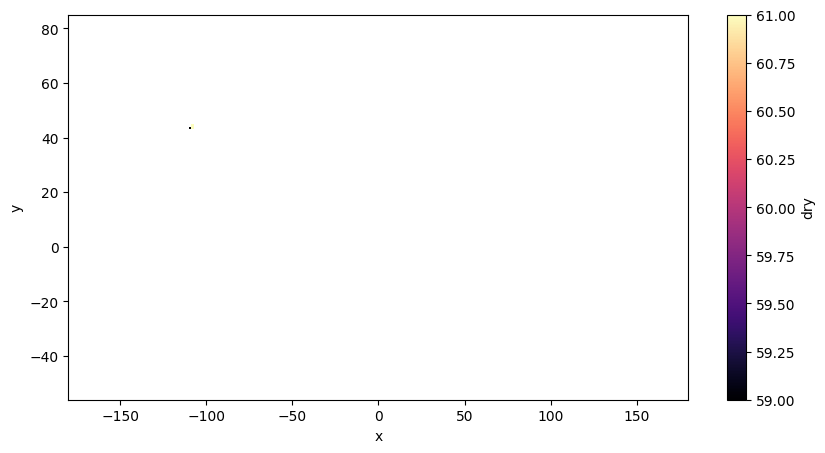

In [13]:
arr.dry.max("time").plot(figsize=(10, 5), cmap="magma")

In [67]:
df = arr.dry.to_series()
# arr.dry
df = df.reset_index()
# df.to_csv("/mnt/e/Term2/payan_name/export/main.csv")
# with pd.ExcelWriter("/mnt/e/Term2/payan_name/export/main.xlsx") as writer: 
#     df.to_excel(writer)

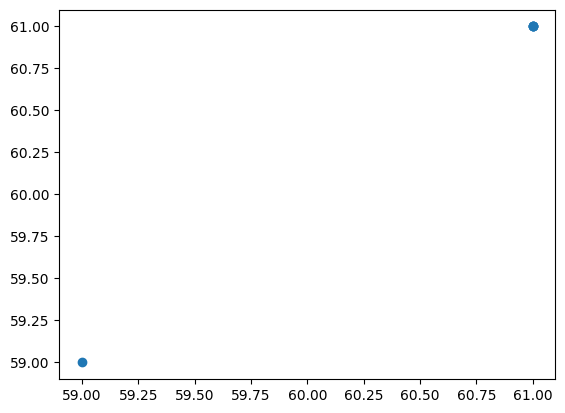

In [22]:

# print(type(arr.dry),arr.dry.size)
b = arr.dry.values
b = list(b.ravel())
# set(list(b.ravel()))
import matplotlib.pyplot as plt 
# plt.plot(b)
# plt.show()
plt.scatter(b, b)

<class 'ee.imagecollection.ImageCollection'>


Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

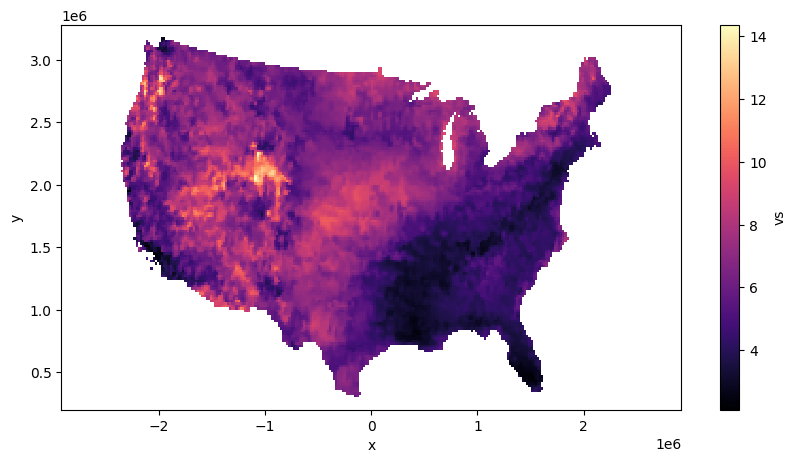

In [14]:
gridmet = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET")
collection = gridmet.filterDate("2020-09-05", "2020-09-11")
print(type(gridmet))
# The coordinate reference system to use (NAD83 Albers CONUS)
crs = "EPSG:5070"
# Spatial resolution in CRS units (meters)
scale = 20_000

arr = collection.wx.to_xarray(scale=scale, crs=crs)
arr.vs.max("time").plot(figsize=(10, 5), cmap="magma")